# Postprocess ISIMIP3b precipitation and temperature data: merging, monthly means and standard deviation!

**the processed monthly ISIMIP3b version 2.5 data are available under: https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/**

- see the fact sheet of isimip3b for more information: https://www.isimip.org/documents/413/ISIMIP3b_bias_adjustment_fact_sheet_gWHNhgH.pdf
    - there you can also find how to cite the used data
- the individual files were downloaded via a wget-script that was produced from https://esg.pik-potsdam.de/search/isimip/:
    - for that you need to login
   
`bash isimip3b/wget-isimip3b_prcp_temp.sh -H`
(you need to registrate to esg and login via terminal)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
# there are 5 gcms available 
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
# two variables: bias-adjusted precipitation and near-surface temperature
typs =['prAdjust', 'tasAdjust']


In [4]:
run = False
if run:
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'

        start = time.time()
        for scenario in scenarios:
            if scenario == 'historical':
                ybegin = 1850
                yend = 2014
            else:
                # for the ssp:
                ybegin = 2015
                yend = 2100
            for typ in typs:

                print(gcm, ensemble, scenario, typ)
                folder_output = 'isimip3b_{}_monthly'.format(typ)
                path_input = 'isimip3b/{}_{}_w5e5_{}_{}_global_daily_*.nc'.format(gcm, ensemble, scenario, typ)
                path_output = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
                # open all at once
                ds = xr.open_mfdataset(path_input, concat_dim='time').load()

                # resample by monthly means, time stamp is of first day of the month
                ds_monthly = ds.resample(time='MS', keep_attrs=True).mean(keep_attrs=True)

                # add some postprocessing attributes
                ds_monthly.attrs['postprocessing_date'] = str(np.datetime64('today','D'))
                ds_monthly.attrs['postprocessing_scientist'] = 'lilian.schuster@student.uibk.ac.at'
                ds_monthly.attrs['postprocessing_actions'] =  ("using xarray: ds = xr.open_mfdataset({}, concat_dim='time') \n"
                                                                  "ds_monthly = ds.resample(time='MS', keep_attrs=True).mean(keep_attrs=True)\n"
                                                                  "ds_monthly.to_netcdf({})\n".format(path_input, path_output))
                # save the file
                ds_monthly.to_netcdf(path_output)

                # if temperature as variable, also compute daily temperature std for each month and save it
                if typ == 'tasAdjust':
                    folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
                    path_output_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)

                    ds_tas_daily_std = ds.resample(time='MS', keep_attrs=True).std(keep_attrs=True)
                    ds_tas_daily_std = ds_tas_daily_std.rename_vars(dict(tasAdjust='tasAdjust_std'))
                    # now have to change variable tas to tas_std and its attributes 
                    ds_tas_daily_std.tasAdjust_std.attrs['standard_name'] = 'air_temperature_daily_std'
                    ds_tas_daily_std.tasAdjust_std.attrs['long_name'] = 'Near-Surface Air Temperature daily standard deviation'
                    ds_tas_daily_std.attrs['postprocessing_date'] = str(np.datetime64('today','D'))
                    ds_tas_daily_std.attrs['postprocessing_scientist'] = 'lilian.schuster@student.uibk.ac.at'
                    ds_tas_daily_std.attrs['postprocessing_actions'] =  ("using xarray: ds = xr.open_mfdataset({}, concat_dim='time') \n"
                                                                      "ds_tas_daily_std = ds.resample(time='MS', keep_attrs=True).std(keep_attrs=True)\n"
                                                                       "ds_tas_daily_std = ds_tas_daily_std.rename_vars(dict(tasAdjust='tasAdjust_std'))\n"
                                                                       "ds_tas_daily_std.tasAdjust_std.attrs['standard_name'] = 'air_temperature_daily_std'\n"
                                                                       "ds_tas_daily_std.tasAdjust_std.attrs['long_name'] = 'Near-Surface Air Temperature daily standard deviation'\n"
                                                                      "ds_tas_daily_std.to_netcdf({})\n".format(path_input, path_output_std))
                    ds_tas_daily_std.to_netcdf('{}'.format(path_output_std))                

        end = time.time()
        print('elapsed time: {} minutes'.format((end - start)/60))
        
        # runs instead via isimip3b_postprocess_to_monthly.py in cluster node
# this produces in total ~75 GB with 60 files (20 files per variable)

**Updated to 0.69 estimate: Note that 0.63 was used in IPCC SROCC and Rounce et al., 2023 for the warming between 1850-1900 and 1986-2005. We use now the more recent IPCC AR6 estimate of 0.69°C.**

In [10]:
import seaborn as sns
import pandas as pd

exp_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]
run = False
if run:
    pd_global_temp_exp = pd.DataFrame(columns=['gcm', 'period_scenario', 'temp_ch_ipcc'])

    typ = 'tasAdjust'
    path = '/home/www/lschuster/isimip3b/'
    temp_change_l = []
    period_scenario_l =[]
    gcm_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'


        folder_output = 'isimip3b_{}_monthly'.format(typ)
        ybegin = 1850
        yend = 2014
        scenario = 'hist'
        path_output = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble,
                                                                                  'historical', typ, ybegin, yend)
        with xr.open_dataset(path_output) as ds_tas_yearly:
            ds_tas_yearly = ds_tas_yearly.groupby('time.year').mean().load()

        ### check the global mean temperature and precipitation time series
        # weighted average over latitudes
        weight = np.cos(np.deg2rad(ds_tas_yearly.lat))
        weight = weight / weight.sum()
        global_tas_mean = (ds_tas_yearly.tasAdjust.mean(dim='lon') * weight).sum(dim='lat') - 273.15  # from K to °C
        ref_period_avg = global_tas_mean.sel(year = slice(str(1986),str(2005))).mean()

        for exp_time in exp_times[:4]:
            exp_period_avg = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
            gcm_l.append(gcm)
            period_scenario_l.append(f'{str(exp_time)}-{str(exp_time+19)}_{scenario}')
            temp_change_l.append((exp_period_avg-ref_period_avg + 0.69).values) # 0.63 was used in IPCC SROCC and Rounce et al., 2023-> but we changed it here to more recent IPCC AR6 estimate of 0.69°C

        for scenario in scenarios[1:]:
            ybegin = 2015
            yend = 2100
            path_output_f = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario,
                                                                                            typ, ybegin, yend)

            with xr.open_dataset(path_output_f) as ds_tas_yearly_f:
                ds_tas_yearly_f = ds_tas_yearly_f.groupby('time.year').mean().load()

            global_tas_mean_f = (ds_tas_yearly_f.tasAdjust.mean(dim='lon') * weight).sum(dim='lat') - 273.15  # from K to °C
            for exp_time in exp_times[4:]:
                exp_period_avg = global_tas_mean_f.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
                gcm_l.append(gcm)
                period_scenario_l.append(f'{str(exp_time)}-{str(exp_time+19)}_{scenario}')
                temp_change_l.append((exp_period_avg-ref_period_avg + 0.69).values) # 0.63 was used in IPCC SROCC and Rounce et al., 2023-> but we changed it here to more recent IPCC AR6 estimate of 0.69°C
            ds_tas_yearly_f.close()
        ds_tas_yearly.close()

    pd_global_temp_exp['gcm'] = gcm_l
    pd_global_temp_exp['period_scenario'] = period_scenario_l
    pd_global_temp_exp['temp_ch_ipcc'] = np.array(temp_change_l)
    #pd_global_temp_exp.to_csv('temp_ch_ipcc_isimip3b.csv')
    #pd_global_temp_exp.to_csv('/home/www/lschuster/glacierMIP3_analysis/temp_ch_ipcc_ar6_isimip3b.csv')
    pd_global_temp_exp.to_csv('../data/temp_ch_ipcc_ar6_isimip3b.csv')

    # temp_ch_ipcc_isimip3b.csv -> used the IPCC SROCC definition of 0.63°C warming 
else:
    pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)


In [12]:
pd_global_temp_exp_ipcc_srocc = pd.read_csv('../data/old_ipcc_srocc/temp_ch_ipcc_isimip3b.csv', index_col = 0)


In [26]:
# ok, IPCC AR6 just shifted by 0.06 compared to IPCC SROCC
np.testing.assert_allclose((pd_global_temp_exp_ipcc_srocc.groupby(['gcm','period_scenario']).mean() - pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()).temp_ch_ipcc.values.mean(),
                           -0.06)
np.testing.assert_allclose((pd_global_temp_exp_ipcc_srocc.groupby(['gcm','period_scenario']).mean() - pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()).temp_ch_ipcc.values.std(),
                           0,atol= 0.001)

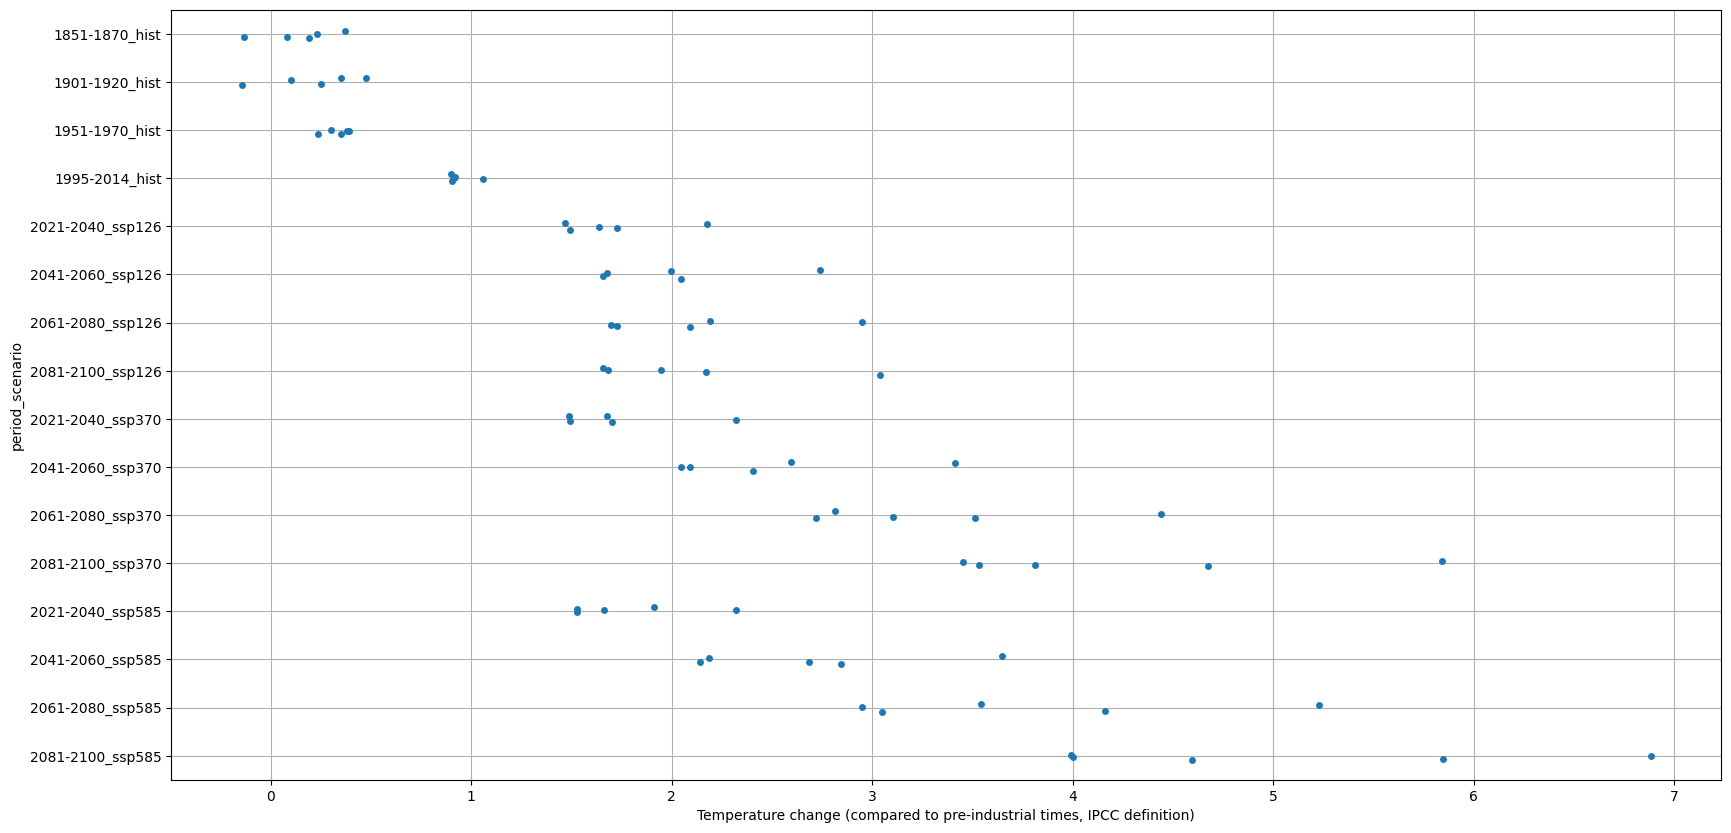

In [27]:
plt.figure(figsize=(20,10))
sns.stripplot(x='temp_ch_ipcc', y = 'period_scenario', data=pd_global_temp_exp)
plt.xlabel('Temperature change (compared to pre-industrial times, IPCC definition)')
plt.grid()

## do some simple checks on the newly generated monthly datasets:

In [ ]:
dict_global_pr_mean= {}
dict_global_tas_mean= {}

for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'prAdjust'
        # '/home/www/lschuster/isimip3b/'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_pr = '/home/www/lschuster/isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        typ = 'tasAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_tas = '/home/www/lschuster/isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = '/home/www/lschuster/isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)


        ds_pr_monthly = xr.open_dataset(path_output_pr)
        ds_tas_monthly = xr.open_dataset(path_output_tas)
        ds_tas_daily_std = xr.open_dataset(path_output_tas_std)

        # right temperature boundaries? actual limits from bias adjustment are: [183.15, 343.15]
        assert np.all(ds_tas_monthly.tasAdjust > 183)  # unit is in K
        assert np.all(ds_tas_monthly.tasAdjust < 344)  # unit is in K

        # right temperature standard deviation
        assert np.all(ds_tas_daily_std.tasAdjust_std >= 0) # std should be above/equal zero
        assert np.all(ds_tas_daily_std.tasAdjust_std.max() < 50) # not too strong differences in between the days of one month

        # right precipitation boundaries?
        # prcp flux: unit is in kg m-2 s-1 (actual limits from bias adjustment are ~ [0, 0.007])
        assert np.all(ds_pr_monthly.prAdjust < 0.007)
        assert np.all(ds_pr_monthly.prAdjust >= 0)

        ### check the global mean temperature and precipitation time series
        # weighted average over latitudes
        weight = np.cos(np.deg2rad(ds_pr_monthly.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_pr_mean = (ds_pr_monthly.prAdjust.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() *60*60*24  # from kg /m2 /s to  mm/day
        global_tas_mean = (ds_tas_monthly.tasAdjust.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() - 273.15  # from K to °C
        print('global precipitation mean: {} mm/day \nglobal temperature mean: {} °C'.format(global_pr_mean.mean().values.round(2), global_tas_mean.mean().values.round(2)))
        # check if they are approximately equal to literature values
        np.testing.assert_allclose(global_pr_mean, 2.6, #  around 2.5-2.7 mm/day on global annual mean
                                   atol = 1.3) # allow to be 2.6 +/- 1.3
        np.testing.assert_allclose(global_tas_mean, 14, # °C  (20th century average)
                                   atol = 10)  # allow to be 14 +/- 10

        dict_global_pr_mean['{}_{}'.format(gcm, scenario)] = global_pr_mean
        dict_global_tas_mean['{}_{}'.format(gcm, scenario)] = global_tas_mean




gfdl-esm4 r1i1p1f1 historical
global precipitation mean: 2.69 mm/day 
global temperature mean: 13.97 °C
gfdl-esm4 r1i1p1f1 ssp126
global precipitation mean: 2.72 mm/day 
global temperature mean: 15.13 °C
gfdl-esm4 r1i1p1f1 ssp370
global precipitation mean: 2.69 mm/day 
global temperature mean: 15.9 °C
gfdl-esm4 r1i1p1f1 ssp585
global precipitation mean: 2.72 mm/day 
global temperature mean: 16.1 °C
ipsl-cm6a-lr r1i1p1f1 historical
global precipitation mean: 2.65 mm/day 
global temperature mean: 13.67 °C
ipsl-cm6a-lr r1i1p1f1 ssp126
global precipitation mean: 2.72 mm/day 
global temperature mean: 15.49 °C
ipsl-cm6a-lr r1i1p1f1 ssp370
global precipitation mean: 2.76 mm/day 
global temperature mean: 16.51 °C
ipsl-cm6a-lr r1i1p1f1 ssp585
global precipitation mean: 2.78 mm/day 
global temperature mean: 17.0 °C
mpi-esm1-2-hr r1i1p1f1 historical
global precipitation mean: 2.66 mm/day 
global temperature mean: 13.8 °C
mpi-esm1-2-hr r1i1p1f1 ssp126


#### check the global mean time series by a plot

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,20))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        ax1.plot(yr, dict_global_pr_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global mean precipitation (mm day$^{-1}$)')
        ax1.set_xlabel('year')
        if ls == '-':
            legend1 = ax1.legend(loc=2, title = 'scenario')
        # ax2.subplot(2,1,2)
        ax2.plot(yr, dict_global_tas_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}_{}'.format(gcm, scenario), color = c, ls = ls, lw=3)
        ax2.set_ylabel('global mean temperature (°C)')
        ax2.set_xlabel('year')
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax1.add_artist(legend1)
plt.tight_layout()
ax1.grid()
ax2.grid()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_global_mean_time_series_pr_temp.pdf');

### check the global mean daily temperature standard deviation

- we either have to assume that all longitudes uncertainty is
    - independent between the grid points (no correlation: square root summing up square stds)
    - or assume that they depend on each other (perfect correlation: sum up stds)
      (for the moment we assume perfect correlation, even if it is wrong...)

In [ ]:
dict_global_tas_std_mean= {}
dict_global_tas_std_mean_1= {}
dict_global_tas_std_mean_7= {}
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']


for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'tasAdjust'
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = '/home/www/lschuster/isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)
        
        ds_tas_daily_std = xr.open_dataset(path_output_tas_std).tasAdjust_std

        weight = np.cos(np.deg2rad(ds_tas_daily_std.lat))
        weight = weight / weight.sum()
        # if we would assume perfect independence (no correlation):
        # should the weight be in squares as well?, I don't think so
        #ds_tas_daily_var = np.square(ds_tas_daily_std)
        #global_tas_daily_std_mean = np.sqrt((ds_tas_daily_var.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean()) #- 273.15  # from K to °C
        #global_tas_daily_std_mean_1 = np.sqrt((ds_tas_daily_var.mean(dim='lon') * weight).sum(dim='lat').sel(time = ds_tas_daily_std['time.month'] == 1)) #- 273.15  # from K to °C
        #global_tas_daily_std_mean_7 = np.sqrt((ds_tas_daily_var.mean(dim='lon') * weight).sum(dim='lat').sel(time = ds_tas_daily_std['time.month'] == 7))
        
        # ok, let's just assume perfect correlation: sum up stds
        global_tas_daily_std_mean = (ds_tas_daily_std.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() #- 273.15  # from K to °C
        global_tas_daily_std_mean_1 = (ds_tas_daily_std.mean(dim='lon') * weight).sum(dim='lat').sel(time = ds_tas_daily_std['time.month'] == 1) #- 273.15  # from K to °C
        global_tas_daily_std_mean_7 = (ds_tas_daily_std.mean(dim='lon') * weight).sum(dim='lat').sel(time = ds_tas_daily_std['time.month'] == 7)
        
        #print('global precipitation mean: {} mm/day \nglobal temperature mean: {} °C'.format(global_pr_mean.mean().values.round(2), global_tas_mean.mean().values.round(2)))
        # check if they are approximately equal to literature values
        # problem: difficult to find literature values ... 
        dict_global_tas_std_mean['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_mean
        dict_global_tas_std_mean_1['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_mean_1
        dict_global_tas_std_mean_7['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_mean_7



In [ ]:
plt.rcParams.update({'font.size': 22})
#
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        ax1.plot(yr, dict_global_tas_std_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global mean daily temperature std (°C)')
        ax1.set_xlabel('year')
        ax1.set_title('mean over months')
        if ls == '-':
            legend1 = ax1.legend(loc=3, title = 'scenario')
        ax2.plot(yr, dict_global_tas_std_mean_1['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax2.set_ylabel(r'global mean daily temperature std(°C)')
        ax2.set_title('January')
        ax2.set_xlabel('year')
        #####
        ax3.plot(yr, dict_global_tas_std_mean_7['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax3.set_ylabel(r'global mean daily temperature std(°C)')
        ax3.set_title('July')
        ax3.set_xlabel('year')
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=3, bbox_to_anchor=(0.2,0), title='GCM')
ax1.add_artist(legend1)
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()


plt.savefig('plots_isimip3b_analysis/plot_isimip3b_global_mean_time_series_temp_std_perfect_correlation.pdf');

- we can see that the temperature variance decrease is mostly in the Northern Hemisphere winter (at least when averaged over the globe), but to do this better we should instead look separately at Northern and Southern Hemisphere!

#### **some literature research on daily temperature standard deviation decrease in the future**:
it seems to be well known that temperature variance decreases in a warmer climate, at least in winter for the Northern Hemisphere:

- **Changes in Northern Hemisphere temperature variability shaped by regional warming patterns**, https://www.nature.com/articles/s41561-020-0576-3.pdf (Tamarin-Brodsky  et al., 2020)
    - see Fig. 1d, 
    - "To first order, the general  decrease  of  the  temperature  gradients  in  winter  leads  to  a  decrease  in  the  temperature  variance,  because,  by  advection  argu-ments,
      a  weaker  gradient  implies  weaker  anomalies "
- **Reduction in Northern Midlatitude 2-m Temperature Variability due to Arctic Sea Ice Loss**: https://doi.org/10.1175/JCLI-D-18-0692.1, (Collow et al., 2019)
    - "It is proposed that the weakened latitudinal temperature gradient, resulting from decreased sea ice, leads to reduced meridional temperature advection variability, which in turn contributes to the reduction in the variability of temperature anomalies. "
- **Arctic amplification decreases temperature variance in northern mid- to high-latitudes**: https://www.nature.com/articles/nclimate2268, (Screen et al., 2014)
    - Consistent with strong Arctic amplification, large decreases in temperature variance are projected in winter (Fig. 4d), and extend further south into mid-latitudes (to 40° N) than they do in autumn. 
    - " In spite of mean climate warming, an ostensibly large number of high-impact cold extremes have occurred in the Northern Hemisphere mid-latitudes over the past decade. One explanation is that Arctic amplification—the greater warming of the Arctic compared with lower latitudes12 associated with diminishing sea ice and snow cover—is altering the polar jet stream and increasing temperature variability. This study shows, however, that subseasonal cold-season temperature variability has significantly decreased over the mid- to high-latitude Northern Hemisphere in recent decades. This is partly because northerly winds and associated cold days are warming more rapidly than southerly winds and warm days, and so Arctic amplification acts to reduce subseasonal temperature variance. "(Screen et al., 2014)